In [1]:
##TRAIN BASS MODEL

import datetime
import psycopg2.extras as pgx
import psycopg2 as pg
import pandas as pd
import numpy as np
import sqlalchemy as sa
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, differential_evolution
import warnings

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)

import helper
import agent_config

$$s(t)=m{\frac {(p+q)^{2}}{p}}{\frac {e^{-(p+q)t}}{(1+{\frac {q}{p}}e^{-(p+q)t})^{2}}}$$

In [2]:
## BASS REGRESSION FUNCTIONS

def bass(X, P, Q):
    # Discrete Bass Model - Returns annual adoption, either as percentage of technical opportunity or as counts
    # 
    # T - Array - Time since adoption started
    # M - Array - Terminal cumulative market
    # P - Scalar - Coefficient of innovation
    # Q - Scalar - Coefficient of imitation
    
    T = X[0,]
    M = X[1,]
    return M * (((P + Q)**2/P) * np.exp(-(P + Q) * T))/(1 + (Q/P) * np.exp(-(P + Q) * T))**2

def findStartingConditions(y, p_bounds, q_bounds, m_bounds):
    """
    Estimate the starting conditions for the Bass model, using the OLS method as documented in Srinivasan & Mason 1986, pg 171
    Assumes that y and m are [0,1], i.e. the adoption counts and market share are fractions of overall market shares
    
    Input: y - numpy array of annual adoption fractions ie. [0,1] NOT counts
    Output: p0, q0, m0 - first stage estimate for p, q, & m parameters
    Example: p0, q0, m0 = findStartingConditions(y)
    """
    
    # Regress the sales (y) on the lagged cumulative sales and the lagged cumulative sales squared
    n = np.concatenate([[0],np.cumsum(y[:-1])])
    n2 = n * n
    x = np.vstack([n, n2]).T
    y = np.array(y, np.newaxis)
    regr = LinearRegression(fit_intercept = True)
    regr.fit(x,y)
    
    # Now we do some arithmatic to recover the p,q,m values
    a1 = regr.intercept_
    a2 = regr.coef_[0]
    a3 = regr.coef_[1]

    m_roots = np.roots([a3, a2, a1]) # Solve for m using a quadratic formula; some of the roots might be imaginary
    if max(m_roots)**2 < 0: 
        m = 0.5
    else:
        m = max(m_roots)
        
    p = a1/m # The p & q calculations are not obvious, but follows the proof in Srinivasan & Mason 1986
    q = -a3*m
    
    p = min(max(p,p_bounds[0]), p_bounds[1])
    q = min(max(q,q_bounds[0]), q_bounds[1])
    m = min(max(m,m_bounds[0]), m_bounds[1])
    
    return [p,q,m]

def findStartingConditionsGA(X,
                             y, 
                             p_bounds,
                             q_bounds,
                            ):
    """
    Estimate the starting conditions for the Bass model, using a genetic algorithm
    Assumes that the adoption counts and market share are fractions of overall market shares
    
    Input: y - numpy array of annual adoption fractions ie. [0,1] NOT counts
    Output: p0, q0, m0 - first stage estimate for p, q, & m parameters
    Example: p0, q0, m0 = findStartingConditions(y)
    """
    # function for genetic algorithm to minimize (sum of squared error)
    # bounds on parameters are set in generate_Initial_Parameters() below
    def sumOfSquaredError(parameterTuple):
        warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
        return np.sum((y - bass(X, *parameterTuple)) ** 2)

    # min and max used for bounds
    parameterBounds = []
    parameterBounds.append(p_bounds) # bounds for p
    parameterBounds.append(q_bounds) # bounds for q

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

def calc_equiv_time(df):
    ''' Calculate the "equivalent time" on the diffusion curve. This defines the
    gradient of adoption.
        IN: msly - numpy array - market share last year [at end of the previous solve] as decimal
            mms - numpy array - maximum market share as decimal
            p,q - numpy arrays - Bass diffusion parameters
            
        OUT: t_eq - numpy array - Equivalent number of years after diffusion 
                                  started on the diffusion curve
    '''
    
    df['mms_fix_zeros'] = np.where(df['max_market_share'] == 0, 1e-9, df['max_market_share'])
    df['ratio'] = np.where(df['market_share_last_year'] > df['mms_fix_zeros'], 0, df['market_share_last_year']/df['mms_fix_zeros'])
    #ratio=msly/mms;  # ratio of adoption at present to adoption at terminal period
    df['teq'] = np.log((1 - df['ratio']) / (1 + df['ratio']*(df['q']/df['p']))) / (-1*(df['p']+df['q'])) # solve for equivalent time
    return df

def bass_diffusion(df):
    ''' Calculate the fraction of population that diffuse into the max_market_share.
        Note that this is different than the fraction of population that will 
        adopt, which is the max market share
        IN: p,q - numpy arrays - Bass diffusion parameters
            t - numpy array - Number of years since diffusion began
            
            
        OUT: new_adopt_fraction - numpy array - fraction of overall population 
                                                that will adopt the technology
    '''
    df['f'] = np.e**(-1*(df['p'] + df['q']) * df['teq2'])
    df['new_adopt_fraction'] = (1-df['f']) / (1 + (df['q']/df['p'])*df['f']) # Bass Diffusion - cumulative adoption
    return df

def bass_simple(T, P, Q, M):
    # Discrete Bass Model - Returns annual adoption counts
    #
    # T - time since adoption started
    # P - Coefficient of innovation
    # Q - Coefficient of imitation
    # M - Terminal (cumulative) market adoption counts
    #
    return (M) * (((P + Q)**2/P) * np.exp(-(P + Q) * T))/(1 + (Q/P) * np.exp(-(P + Q) * T))**2

def estimate_max_market_share(t, y, lower_bound, upper_bound):
    """
    Estimate the maximum market share, if other estimation methods are unavailable. 
    The process for using this would look something like:
    1) Use this function to estimate an initial maximum market share
    2) Use the maxium market share to estimate p and q values
    3) Run dGen with those p and q values
    4) Use the economic maximum market share determined by dGen to estimate new p and q values
    5) Run dGen with those values moving forward
    """
    fitted, _ = curve_fit(f = bass_simple,
                           xdata = t,
                           ydata = y,
                           bounds = ([1e-5, 1e-5, lower_bound], [.2,.8, upper_bound]),
                           max_nfev = 100000)
    return fitted[2]


In [98]:
# --- Load agents ---
agents = pd.read_csv(os.path.join('india_base','agent_core_attributes.csv'))

# --- groupby sector/state_name ---
agents = agents.groupby(['sector_abbr','state_name','state_id'], as_index=False)['customers_in_bin'].sum()

# --- Load adoption ---
adopt = pd.read_csv(os.path.join('reference_data','clean_pv_installed_all_years.csv'))
df = agents.merge(adopt, on=['sector_abbr','state_name','state_id'], how='left')
df = df[~df['year'].isnull()]
df = df.sort_values(['sector_abbr', 'state_name', 'year'], ascending=True)

# --- make cumulative ---
df[['cum_mw','cum_installed_count']] = df.groupby(['sector_abbr','state_name','state_id','customers_in_bin'])[['annual_installed_mw','annual_installed_count']].transform('cumsum')

# --- create market_share ---
system_size_dict = {'res':1, 'com':10, 'ind':100} #based on avg rootop size
df['max_mw'] = df['sector_abbr'].map(system_size_dict) * df['customers_in_bin'] / 1000 * 0.8
df['market_share'] = df['annual_installed_mw'] / df['max_mw']
df['market_share'] = df['market_share'].fillna(0)

df


,sector_abbr,state_name,state_id,customers_in_bin,year,cum_mw,cum_installed_count,annual_installed_mw,annual_installed_count,max_mw,market_share
18,com,andaman_nicobar_islands,35,26663.0,2011.0,0.000000,0.000000,0.000000,0.000000,213.3040,0.000000
19,com,andaman_nicobar_islands,35,26663.0,2012.0,0.000000,0.000000,0.000000,0.000000,213.3040,0.000000
20,com,andaman_nicobar_islands,35,26663.0,2013.0,0.000000,0.000000,0.000000,0.000000,213.3040,0.000000
21,com,andaman_nicobar_islands,35,26663.0,2014.0,0.000000,0.000000,0.000000,0.000000,213.3040,0.000000
22,com,andaman_nicobar_islands,35,26663.0,2015.0,0.000000,0.000000,0.000000,0.000000,213.3040,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1146,res,west_bengal,19,36684567.0,2017.0,10.567961,2641.990291,4.844660,1211.165049,29347.6536,0.000165
1147,res,west_bengal,19,36684567.0,2018.0,32.878465,8219.616205,22.310504,5577.625913,29347.6536,0.000760
1148,res,west_bengal,19,36684567.0,2019.0,52.878754,13219.688417,20.000289,5000.072213,29347.6536,0.000681
1149,res,west_bengal,19,36684567.0,2020.0,79.972906,19993.226462,27.094152,6773.538045,29347.6536,0.000923


In [99]:

def fit_bass(df, pbounds=[1e-7, 0.03], qbounds=[1e-7, 0.8], max_market_pct=0.5):

    # Loop over each region and sector and calculate the p,q, and m parameters.
    l = []

    # Options for constraining market size - 'max_market' is recommended
    market_size_method = 'max_developable_market'
        # 'max_market' : Use the max market implied by the hot run, i.e. max_market_share * customers_in_bin
        # 'max_developable_market' : Use the max developable market set in the hot run, i.e. the max developable number of customers
        # 'free' : Don't contrain the market size and use the terminal market size determinded by the regression

    # Options for setting the first year of adoption
    first_year_method = 'first_value'
        # INT : Set an integer value to use as the first year (t = 1) consistently across all regions
        # 'first_value' : Use the first year observed in each region, i.e. may differ by regions
        

    for state in df['state_name'].unique():
        for sector in df['sector_abbr'].unique():
            
            sub = df.loc[(df['state_name'] == state) & (df['sector_abbr'] == sector)]
            sub = sub.reset_index(drop=True)
            if len(sub) > 0:

                if first_year_method == 'first_value':
                    sub_t = sub['year'] - sub['year'].min() + 1 #years since t1

                else:
                    sub = sub[(sub['year'] >= first_year_method)]
                    sub_t = sub['year'] - first_year_method + 1

                if market_size_method == 'max_market':
                    # --- create max market ---
                    m0 = estimate_max_market_share(sub_t, sub['market_share'], lower_bound=1e-5, upper_bound=max_market_pct)
                    sub_y = np.full(sub_t.shape, m0)

                elif market_size_method == 'max_developable_market':
                    m0 = estimate_max_market_share(sub_t, sub['market_share'], lower_bound=1e-5, upper_bound=max_market_pct)
                    sub_y = np.array(sub['market_share']) #percent of adopters relative to all customers

                elif market_size_method == 'free':
                    sub_y = sub['n_adopters'] #number of adopters

                try:
                    X = np.empty((2,sub_y.shape[0])) #shape of 2xlen(st_y)
                    X[0,] = sub_t #years since first year
                    # X[1,] = st['max_market'] / st['developable_customers']
                    X[1,] = 1.
                    #Use genetic algorithm to find the starting conditions for optimization
                    # p0, q0, m0 = findStartingConditions(y=sub_y, p_bounds=pbounds, q_bounds=qbounds, m_bounds=[0,max_market_pct])

                    p0, q0 = findStartingConditionsGA(X=X, y=sub_y, p_bounds=pbounds, q_bounds=qbounds)
                    # p0, q0 = 0.002285, 0.5733 #from mexico averages

                    # Solve for the p & q parameters
                    assert len(sub_y) > 0
                    popt, pcov = curve_fit(
                                        f = bass,
                                        xdata = X,
                                        ydata = sub_y,
                                        p0 = [p0, q0],
                                        bounds = ([pbounds[0],qbounds[0]], [pbounds[1], qbounds[1]]),
                                    )

                    # pcov is the covariance matrix of the coefficients. Thus, the diagonal of the matrix is the variance, and the 
                    # square root of the variance are the standard errors (SE). We can say the coefficients are approximately significant
                    # at 95% confidence interval if (ABS(coef) - 2 * standard error) > 0, ie the coefficient is > 2 standard errors
                    # from zero
                    SE = np.sqrt(np.diag(pcov))
                    l.append([state, sector, 2020, sub_y[-1], popt[0], SE[0], popt[1],SE[1], m0, 'Converged w/ bounds'])
                    print(f"{state} {sector}: p {round(popt[0],4)}, q {round(popt[1],4)}, m {round(m0,4)}")

                except ValueError:
                    l.append([state, sector, 2020, sub_y[-1], np.nan, np.nan, np.nan, np.nan, m0, 'Infeasible'])
                    print(f'{state} infeasible')

    print('\n All Done!')
    bass_params = pd.DataFrame(l)
    bass_params.columns = ["state_name","sector_abbr","year","pred","p","p_SE","q","q_SE", "m", "status"]
    bass_params['p_sig'] = bass_params['p'] - 2 * bass_params['p_SE'] > 0
    bass_params['q_sig'] = bass_params['q'] - 2 * bass_params['q_SE'] > 0
    bass_params['pred'].fillna(0, inplace=True)

    # --- fill insignificant values ---
    for sector in df['sector_abbr'].unique():
        sector_mask = (bass_params['sector_abbr'] == sector)
        ann_installs_mask = (bass_params['pred'] > 0)
        p_mask = (bass_params['p_sig'] == True)
        q_mask = (bass_params['q_sig'] == True)

        avgs = bass_params.loc[sector_mask & ann_installs_mask & q_mask, ['p','q','m']].mean()

        bass_params.loc[sector_mask & ~ann_installs_mask,'p'] = avgs['p']
        bass_params.loc[sector_mask & ~ann_installs_mask,'q'] = avgs['q']
        bass_params.loc[sector_mask & ~ann_installs_mask,'m'] = avgs['m']

    # --- clip max market share ---
    bass_params['m'].clip(bass_params['m'].quantile(0.75))

    # --- map state ids ---
    state_id_lookup = pd.read_csv(os.path.join('reference_data', 'india_census','state_id_lookup.csv'))
    state_id_lookup = dict(zip(state_id_lookup['state_name'], state_id_lookup['state_id']))

    bass_params['state_id'] = bass_params['state_name'].map(state_id_lookup)

    # --- format for csv ---
    out = bass_params[['state_id', 'sector_abbr', 'p', 'p_SE', 'q', 'q_SE', 'm', 'p_sig','q_sig']]

    # all_out = []
    # for sect in ['res','com','ind']:
    #     sect_out = out.copy()
    #     sect_out['sector_abbr'] = sect
    #     all_out.append(sect_out)
    # out = pd.concat(all_out, axis='rows')

    out.to_csv(os.path.join('india_base','pv_bass.csv'), index=False)
    out.to_csv(os.path.join(os.pardir,'input_scenarios','india_base','pv_bass.csv'), index=False)

    return bass_params

andaman_nicobar_islands com: p 0.0001, q 0.1, m 0.0043
andaman_nicobar_islands ind: p 0.0001, q 0.1, m 0.0043
andaman_nicobar_islands res: p 0.0001, q 0.1, m 0.0043
andhra_pradesh com: p 0.0001, q 0.2746, m 0.608
andhra_pradesh ind: p 0.0004, q 0.4048, m 0.1474
andhra_pradesh res: p 0.0001, q 0.2463, m 0.1507
arunachal_pradesh com: p 0.0001, q 0.1, m 0.0043
arunachal_pradesh ind: p 0.0001, q 0.1, m 0.0043
arunachal_pradesh res: p 0.0001, q 0.1, m 0.0043
assam com: p 0.0001, q 0.1, m 0.0043
assam ind: p 0.0001, q 0.1, m 0.0043
assam res: p 0.0001, q 0.1, m 0.0043
bihar com: p 0.0001, q 0.1, m 0.0473
bihar ind: p 0.0001, q 0.1984, m 0.9714
bihar res: p 0.0001, q 0.1, m 0.0055
chandigarh com: p 0.0003, q 0.3644, m 0.9999
chandigarh ind: p 0.0013, q 0.4236, m 1.0
chandigarh res: p 0.0008, q 0.3556, m 1.0
chhattisgarh com: p 0.0001, q 0.1345, m 1.0
chhattisgarh ind: p 0.0003, q 0.3879, m 0.0998
chhattisgarh res: p 0.0001, q 0.1595, m 0.9983
daman_diu com: p 0.0001, q 0.1, m 0.0043
daman_diu

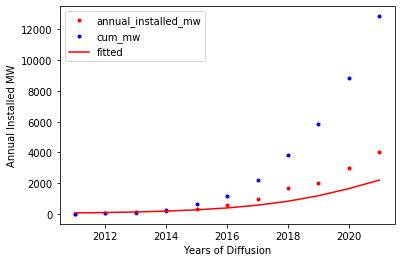

In [100]:
bass_params = fit_bass(df,
                    pbounds=[1e-4, 0.1],
                    qbounds=[0.1, 0.8],
                    max_market_pct=1)

# How well does the regress fit the historic data?
fit = df.merge(bass_params[['state_name','sector_abbr','p','q','m']], on=['state_name','sector_abbr'])

X = np.empty((2,fit.shape[0]))
X[0,] = fit['year'] - 2010
X[1,] = fit['m']
fit['bass_market_share'] = bass(X,fit['p'],fit['q'])
fit['bass_pred'] = fit['bass_market_share'].clip(0, fit['m']) * fit['max_mw']
# fit['bass_pred'] = fit['bass_market_share'] * fit['customers_in_bin']
cfit = fit.groupby('year').sum().reset_index()

## Plot Bass Curve
# This plots the historic and simulated Bass fits.
# plt.plot(cfit['year'], cfit['annual_installed_count'], 'r.', label='annual_installed_count')
# plt.plot(cfit['year'], cfit['cum_installed_count'], 'b.', label='cum_installed_count')
plt.plot(cfit['year'], cfit['annual_installed_mw'], 'r.', label='annual_installed_mw')
plt.plot(cfit['year'], cfit['cum_mw'], 'b.', label='cum_mw')
plt.plot(cfit['year'], cfit['bass_pred'], 'r-', label='fitted')

plt.xlabel('Years of Diffusion')
plt.ylabel('Annual Installed MW')
plt.legend(loc = 2)
plt.show()

In [95]:
bass_params.loc[(bass_params['p_sig']==True) & (bass_params['q_sig']==True)].mean()

year        2020.000000
pred           0.040864
p              0.000419
p_SE           0.000125
q              0.362574
q_SE           0.035798
m              0.448262
p_sig          1.000000
q_sig          1.000000
state_id      19.200000
dtype: float64

In [101]:
bass_params

,state_name,sector_abbr,year,pred,p,p_SE,q,q_SE,m,status,p_sig,q_sig,state_id
0,andaman_nicobar_islands,com,2020,0.000000,0.000114,0.000099,0.273123,0.118156,0.431629,Converged w/ bounds,False,False,35
1,andaman_nicobar_islands,ind,2020,0.000000,0.000471,0.000099,0.405224,0.118156,0.543954,Converged w/ bounds,False,False,35
2,andaman_nicobar_islands,res,2020,0.000000,0.000148,0.000099,0.246618,0.118156,0.537817,Converged w/ bounds,False,False,35
3,andhra_pradesh,com,2020,0.002190,0.000100,0.000033,0.274600,0.034001,0.608036,Converged w/ bounds,True,True,28
4,andhra_pradesh,ind,2020,0.028193,0.000416,0.000243,0.404840,0.056370,0.147437,Converged w/ bounds,False,True,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,west_bengal,com,2020,0.000452,0.000100,0.000060,0.105327,0.071435,0.004883,Converged w/ bounds,False,False,19
99,west_bengal,ind,2020,0.008309,0.000158,0.000102,0.368847,0.062905,0.055710,Converged w/ bounds,False,True,19
100,west_bengal,res,2020,0.001231,0.000100,0.000052,0.219598,0.055212,0.008028,Converged w/ bounds,False,True,19
101,dadra_nagar_haveli,ind,2020,0.000000,0.000471,0.000099,0.405224,0.118156,0.543954,Converged w/ bounds,False,False,26
